In [2]:
from itertools import combinations
import numpy as np
from z3 import *
import utils
import SAT_constraints
import logging

In [3]:
# Define your preferred logging level
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO)

In [4]:
WIDTH = 0
HEIGHT = 1

In [5]:
# Ensures that the circuits are connected
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    constraints = []
    for c in range(1, n + 1):
        c_constraints = []
        height = dims[c - 1][HEIGHT]
        width = dims[c - 1][WIDTH]
        for x in range(w - (width - 1)):
            for y in range(upper_bound - (height - 1)):
                normal = []
                rotated = []
                # Should it be strictly less than or less than and equal here?
                rotation_possible = ((x+height) < w) and ((y+width) < upper_bound) and (width != height)
                for i in range(width):
                     for j in range(height):
                         normal.append(bool_vars[x+i][y+j][c])
                         if rotation_possible: 
                             rotated.append(bool_vars[x+j][y+i][c])
                
                c_constraints.append(And(normal))
                if len(rotated)>0:
                    c_constraints.append(And(rotated))
        # constraints.append(Or(c_constraints))  
        ex = SAT_constraints.exactly_one_seq(c_constraints, f"coherent_{c}")
        constraints.append(ex)
              
    return And(constraints)



In [6]:
def create_contraints(w, n, dims, upper_bound):
    s = Solver()

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(0, n + 1)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            s.add(SAT_constraints.at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))    
    
    # Ensure the right amount of empty cells -> Ensures that each circuit don't expand more than their dimension
    total_white_cells = (upper_bound * w) - sum(dims[:, WIDTH] * dims[:, HEIGHT])
    if total_white_cells > 0:
        predicate = [v[x][y][0] for x in range(w) for y in range(upper_bound)]
        s.add(SAT_constraints.exactly_k_seq(predicate, total_white_cells, f"white_cells_{x}_{y}_{0}"))
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    return s, v

In [7]:
def compute_lb(w, dims):
    n_rows = math.ceil(sum(dims[:, WIDTH]) / w)
    sorted_heights = sorted(dims[:, HEIGHT])
    lb = np.sum(sorted_heights[:n_rows])
    l = lb if lb >= max(dims[:, HEIGHT]) else max(dims[:, HEIGHT])
    return l

In [8]:
def compute_solution(model: ModelRef, v, w, n, l):
    sol = []

    for x in range(w):
        sol.append([])
        for y in range(l):
            found_circuit = False
            for c in range(1, n + 1):
                if model.evaluate(v[x][y][c]):
                    found_circuit = True
                    sol[x].append(c)
            if not found_circuit:
                sol[x].append(0)
    return sol

In [32]:
def vlsi_design(instance_number: int, visualize = True) -> None:
    file_path = f"../instances/ins-{instance_number}.txt"
    w, n, dims = utils.read_output(file_path)
    l = compute_lb(w, dims)
    s, v = create_contraints(w, n, dims, l)

    while(not s.check()==sat):
        logging.info(f"Trying again with l= {l+1}")
        l += 1
        s, v = create_contraints(w, n, dims, l)

    model = s.model()
    sol = compute_solution(model, v, w, n, l)
    if visualize:
        utils.visualize_w_color_rotation(sol, w, len(sol[0]), dims, title=f"Instance {instance_number}, l={l}")
    return w, n, l, dims, sol, model

### Run the SAT VLSI-Design

In [95]:
# Parse the solution to correct output form
def output_results(w, l, n, dims, sol):
    str = f"{w} {l}\n{n}"

    pos = {}
    for x in range(w):
      for y in range(l-1, 0, -1):
          c = sol[x][y]

          if c != 0 and c not in pos:
              pos[c] = [x, (l-1) - y]

              numb = sol[x].count(c)
              if numb != dims[c-1][1]:
                  pos[c].append("R")
          
    for i in range(n):
      rotated = 0
      if (len(pos.get(i + 1)) > 2):
        rotated = 1
      str += f"\n{dims[i][WIDTH + rotated]} {dims[i][HEIGHT - rotated]} {pos.get(i + 1)[0]} {pos.get(i + 1)[1]}"
    
    return str
    

    



[INFO] Trying again with l= 7
[INFO] Trying again with l= 8


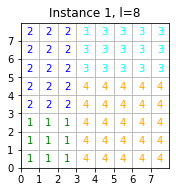

8 8
4
3 3 0 0
3 5 0 3
5 3 3 5
5 5 3 0


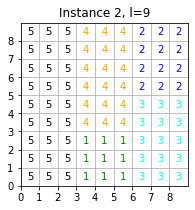

9 9
5
3 3 3 0
3 4 6 5
3 5 6 0
3 6 3 3
3 9 0 0


[INFO] Trying again with l= 8
[INFO] Trying again with l= 9
[INFO] Trying again with l= 10


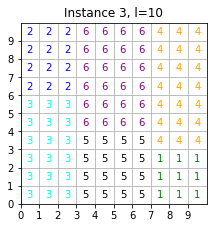

10 10
6
3 3 7 0
3 4 0 6
3 6 0 0
3 7 7 3
4 4 3 0
4 6 3 4


[INFO] Trying again with l= 11


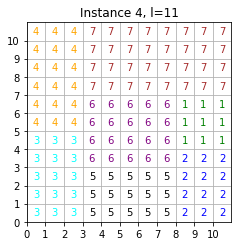

11 11
7
3 3 8 4
3 4 8 0
3 5 0 0
3 6 0 5
5 3 3 0
5 4 3 3
8 4 3 7


[INFO] Trying again with l= 11
[INFO] Trying again with l= 12


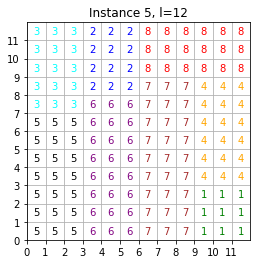

12 12
8
3 3 9 0
3 4 3 8
3 5 0 7
3 6 9 3
3 7 0 0
3 8 3 0
3 9 6 0
6 3 6 9


[INFO] Trying again with l= 11
[INFO] Trying again with l= 12
[INFO] Trying again with l= 13


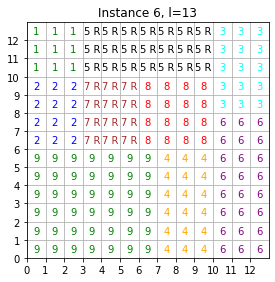

13 13
9
3 3 0 10
3 4 0 6
3 5 10 8
3 6 7 0
7 3 3 10
3 8 10 0
3 4 3 6
4 4 6 6
7 6 0 0


[INFO] Trying again with l= 12
[INFO] Trying again with l= 13
[INFO] Trying again with l= 14


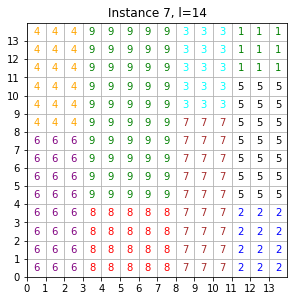

14 14
9
3 3 11 11
3 4 11 0
3 5 8 9
3 6 0 8
3 7 11 4
3 8 0 0
3 9 8 0
5 4 3 0
5 10 3 4


In [96]:
for i in range(1, 8):
    w, n, l, dims, sol, model = vlsi_design(i)
    output = output_results(w, l, n, dims, sol)
    print(output)

